# <center> Optimization </center>
## <center> Stochastic Programming

In [1]:
!pip install gurobipy
import pandas as pd
import numpy as np
import gurobipy as gp
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('price_demand_data.csv')

df.head()

,price,demand
0,1.05,283
1,0.86,771
2,1.21,185
3,0.94,531
4,0.76,1002


## PART A

### Fit linear regression to price demand data and determine residuals associated with the linear regression model

In [4]:
X = df.price.to_numpy().reshape(-1,1)
y = df.demand.to_numpy().reshape(-1,1)

lr = LinearRegression()

lr.fit(X, y)

pred = lr.predict(X)

# residuals between predicted demand and actual demand
resid = y - pred


#### When price is $1

In [5]:
# regular printing cost
c = 0.5
# rush order printing cost
g = 0.75
# disposal cost
t = 0.15
# price
p = 1

# Predicted demand when price = 1:
pred_demand_1 = lr.predict(np.ones(len(resid)).reshape(-1, 1))

# Create a distribution of demand with price = $1 using residuals
demand_1 = pred_demand_1 + resid

# Number of days
nday = len(demand_1)

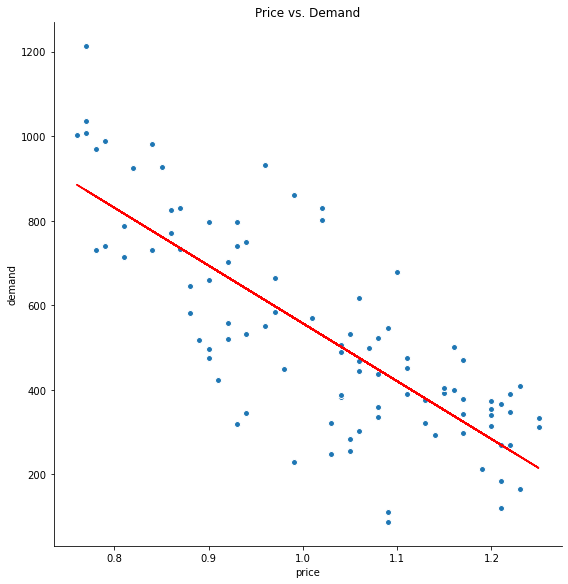

In [17]:
g = sns.FacetGrid(df, size = 8)
g = g.map(plt.scatter, 'price', 'demand', edgecolor="w")
y_plot = lr.intercept_ + lr.coef_ * X
plt.plot(X, y_plot, color='r')
plt.title('Price vs. Demand')
plt.show()

## PART B

### Finding the Optimal Quantity to Print (Given Price)

In [6]:
'''
We are optimizing a single quantity--Q such that each day's profit--H is being maximized

In other words, our decision variables are:

Q, H1, ... ,H_nday

For each day ranging from 1 to nday, it is subject to the following conditions:

q * [c-g] + h <= p*Di - g*Di when Di >= q

q * [c+t] + h <= p*Di + t*Di when Di < q


'''

# Objective function
obj = np.zeros(nday + 1)
obj[1:] = 1.0/nday

# Set lower bounds
lb = np.zeros(nday + 1)
lb[1:] = -np.inf

# Direction of constraints
direction = np.array(['<'] * (2*nday))

# Initiate constraint matrix A as well as its rhs
rhs = np.zeros(2*nday)
A = np.zeros((2*nday, nday+1))

# Fill in the constraint matirx A:
for i in range(nday):

  A[2*i, [0, 1+i]] = [(c-g), 1]
  rhs[2*i] = (p-g) * demand_1[i]

  A[2*i + 1, [0, 1+i]] = [(c+t), 1]
  rhs[2*i + 1] = (p+t) * demand_1[i]


var_type = ['I'] + ['C'] * nday

In [7]:
#Optimize

spMod = gp.Model()
spMod_x = spMod.addMVar(len(obj),lb=lb,vtype = var_type) # tell the model how many variables there are
# must define the variables before adding constraints because variables go into the constraints
spMod_con = spMod.addMConstrs(A, spMod_x, direction, rhs) # NAME THE CONSTRAINTS!!! so we can get information about them later!
spMod.setMObjective(None,obj,0,sense=gp.GRB.MAXIMIZE) # add the objective to the model...we'll talk about the None and the 0

spMod.Params.OutputFlag = 0 # tell gurobi to shut up!!
spMod.optimize()


Set parameter Username
Academic license - for non-commercial use only - expires 2022-08-27


In [8]:
print('The optimal quantity to order is {} which results in an expected profit of ${} per day'.format(\
                                               spMod_x.x[0], round(spMod.objval,2)))


The optimal quantity to order is 472.0 which results in an expected profit of $231.48 per day


## PART C

### Steps to Finding the Optimal Quantity to Print (When Price Influences Demand)

In [9]:
'''
We are optimizing over both P and Q to find an equilibrium point.

To do so we maximize the profit of the business where,
     profit = Sales - Cost = Sales + (-Cost) = p * D_i + H

To be more specific:

p * D_i = p * (b0 + b1*p + e_i) = p*b1*p + p*(b0 + e_i)

H_i  = - [q*c + g*(D_i - q)' + t*(q - D_i)']
     = - {q*c + g*[(b0 + b1*p + e_i) - q]' + t*[q - (b0 + b1*p + e_i)]'}

With the Quadratic term being: 
                              p*b1*p

and the Linear term being: 
      p*(b0 + e) - {q*c + g*[(b0 + b1*p + e) - q]' + t*[q - (b0 + b1*p + e)]'}


Therefore, our decision variables are:
P, Q, H1, H2, ..., H_nday


subjects to the constraints (per day i/ each residual):

           H_i  <= - [q*c + g*(D_i - q)' + t*(q - D_i)']
                           or
     H_i  <= - {q*c + g*[(b0 + b1*p + e_i) - q]' + t*[q - (b0 + b1*p + e_i)]'}


Restated as follow:

When Di >= q:

Hi <= -q*c - g*(Di-q) = -q*c - g*((b0 + b1*p + e_i)-q)

Hi + (c-g)*q + g*b1*p <= -g*b0 - g*ei


When Di < q:

Hi <= -q*c - t*(q-Di) = -q*c - t*(q-(b0 + b1*p + e_i))

Hi + (c+t)*q - t*b1*p <= t*b0 + t*ei

'''
# regular printing cost
c = 0.5
# rush order printing cost
g = 0.75
# disposal cost
t = 0.15
# Number of days
nday = len(resid)

b0 = lr.intercept_
b1 = lr.coef_

# Initiate objective for the linear term
obj_linear = np.zeros(nday + 2)
obj_linear[[0 ,1]] = [b0+np.mean(resid), 0]
obj_linear[2:] = 1.0 / nday

#Initiate objective for the quadratic term
obj_quad =  np.zeros((nday + 2, nday + 2))
obj_quad[0,0] = b1

# Set upper bounds
ub = np.zeros(nday + 2)
ub[:2] = np.inf
ub[2:] = 0 # negative costs are always negative

# Set lower bounds
lb = np.zeros(nday + 2)
lb[2:] = -np.inf

# Initiate constraint matrix
A = np.zeros((nday*2, nday+2))
rhs = np.zeros(nday*2)
dir = np.array(['<'] * nday*2)

# Set up constraints accordingly
for i in range(nday):

  # g*b1*p + (c-g)*q + Hi  <= -g*b0 - g*ei
  A[2*i, [0, 1, 2+i]] = [g*b1, (c-g), 1]
  rhs[2*i] = -g*b0 - g*resid[i]

  # - t*b1*p + (c+t)*q + Hi  <= t*b0 + t*ei
  A[2*i + 1, [0, 1, 2+i]] = [-t*b1, (c+t), 1]
  rhs[2*i + 1] = t*b0 + t*resid[i]

var_type = ['C','I'] + ['C'] * nday

#Optimize

spMod2 = gp.Model()
spMod2_x = spMod2.addMVar(len(obj_linear),lb=lb, ub=ub,vtype=var_type) # tell the model how many variables there are
# must define the variables before adding constraints because variables go into the constraints
spMod2_con = spMod2.addMConstrs(A, spMod2_x, dir, rhs) # NAME THE CONSTRAINTS!!! so we can get information about them later!
spMod2.setMObjective(obj_quad,obj_linear,0,sense=gp.GRB.MAXIMIZE) # add the objective to the model...we'll talk about the None and the 0

spMod2.Params.OutputFlag = 0 # tell gurobi to shut up!!
spMod2.optimize()

In [10]:
print('The optimal price is ${} and optimal quantity to order is {} \
which results in an expected profit of ${} per day'.format(\
           round(spMod2_x.x[0],2), spMod2_x.x[1], round(spMod2.objval,2)))

The optimal price is $0.95 and optimal quantity to order is 535.0 which results in an expected profit of $234.42 per day


## PART D

### Take bootstrap sample and re-optimize to figure out optimal price and quantity to order

In [11]:
# Write a function to automate the optimization process

def optimize(df, n=1):

  # Randomly select rows with replacment: bootstraping 
  ind = np.random.choice(np.arange(99), replace=True, size=len(df)*n).tolist()

  # Extract sample
  sample = df.loc[ind,:]

  # Fit linear regression, extract residuals and coefficients 
  X = sample.price.to_numpy().reshape(-1,1)
  y = sample.demand.to_numpy().reshape(-1,1)

  lr = LinearRegression()
  lr.fit(X, y)
  pred = lr.predict(X)

  # residuals between predicted demand and actual demand
  resid = y - pred

  # regular printing cost
  c = 0.5
  # rush order printing cost
  g = 0.75
  # disposal cost
  t = 0.15
  # Number of days
  nday = len(resid)

  b0 = lr.intercept_
  b1 = lr.coef_

  # Initiate objective for the linear term
  obj_linear = np.zeros(nday + 2)
  obj_linear[[0 ,1]] = [b0+np.mean(resid), 0]
  obj_linear[2:] = 1.0 / nday

  #Initiate objective for the quadratic term
  obj_quad =  np.zeros((nday + 2, nday + 2))
  obj_quad[0,0] = b1

  # Set upper bounds
  ub = np.zeros(nday + 2)
  ub[:2] = np.inf
  ub[2:] = 0 # negative costs are always negative

  # Set lower bounds
  lb = np.zeros(nday + 2)
  lb[2:] = -np.inf

  # Initiate constraint matrix
  A = np.zeros((nday*2, nday+2))
  rhs = np.zeros(nday*2)
  dir = np.array(['<'] * nday*2)

  # Set up constraints accordingly
  for i in range(nday):

    # g*b1*p + (c-g)*q + Hi  <= -g*b0 - g*ei
    A[2*i, [0, 1, 2+i]] = [g*b1, (c-g), 1]
    rhs[2*i] = -g*b0 - g*resid[i]

    # - t*b1*p + (c+t)*q + Hi  <= t*b0 + t*ei
    A[2*i + 1, [0, 1, 2+i]] = [-t*b1, (c+t), 1]
    rhs[2*i + 1] = t*b0 + t*resid[i]
  
  var_type = ['C','I'] + ['C'] * nday

  #Optimize

  spMod2 = gp.Model()
  spMod2_x = spMod2.addMVar(len(obj_linear),lb=lb, ub=ub,vtype=var_type) # tell the model how many variables there are
  # must define the variables before adding constraints because variables go into the constraints
  spMod2_con = spMod2.addMConstrs(A, spMod2_x, dir, rhs) # NAME THE CONSTRAINTS!!! so we can get information about them later!
  spMod2.setMObjective(obj_quad,obj_linear,0,sense=gp.GRB.MAXIMIZE) # add the objective to the model...we'll talk about the None and the 0

  spMod2.Params.OutputFlag = 0 # tell gurobi to shut up!!
  spMod2.optimize()
  
  # return price, quantity, expected return
  return  spMod2_x.x[0], spMod2_x.x[1], spMod2.objval




In [12]:
optimal = pd.DataFrame(columns=['price', 'quantity', 'profit'])

for i in range(1000):
  price, quant, prof = optimize(df)
  optimal.loc[i, :] = [price, quant, prof]

In [13]:
print('The optimal price is ${} and the optimal quantity is {},\
 which results in an expected profit of ${}'.format(\
          round(optimal.price.mean(),2), int(optimal.quantity.mean()), round(optimal.profit.mean(),2)))

The optimal price is $0.95 and the optimal quantity is 536, which results in an expected profit of $235.24


### Joint plot histogram and scatter plot of Optimal Quantity vs Price

Text(0.5, 0.98, 'Optimal Quantity versus Price')

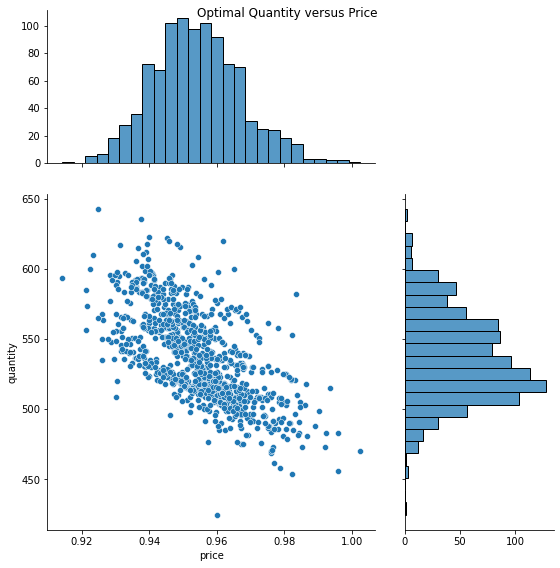

In [14]:
sns.jointplot(data=optimal,x='price',y='quantity',height=8,ratio=2,marginal_ticks=True)
plt.suptitle('Optimal Quantity versus Price')

### Expected Profits

Text(0.5, 1.0, 'Expected Profits')

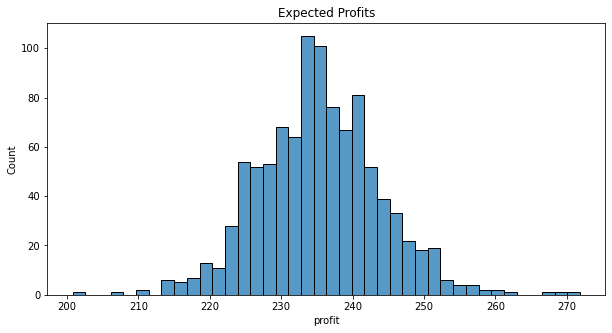

In [15]:
plt.figure(figsize=(10,5))
sns.histplot(data=optimal, x="profit",bins=40)
plt.title('Expected Profits')

## END-OF-CODE